# Train Set

In [1]:
import pandas as pd

train_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/train_set.csv"
)
train_df = pd.read_csv(train_set_path)
train_df = train_df.sample(frac=0.2, random_state=42)
print(f"train set count: {train_df.shape[0]:,}")
train_df.head(3)

train set count: 10,775


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
28282,-0.102571,-0.007723,-0.004728,-0.014089,-0.089487,-0.007736,1.765416,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
19433,-0.110250,-0.007666,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
30618,-0.110250,-0.007733,-0.004414,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432


# Validation Set

In [2]:
import pandas as pd

val_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/validation_set.csv"
)
val_df = pd.read_csv(val_set_path)
val_df = val_df.sample(frac=0.2, random_state=42)
print(f"train set count: {val_df.shape[0]:,}")
val_df.head(3)

train set count: 5,039


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
13984,-0.11025,-0.007725,-0.004856,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,1,normal,normal
17498,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,1,normal,normal
6455,-0.11025,-0.007703,-0.004812,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,1,normal,normal


In [3]:
X_val = val_df.drop(columns=["attack_binary", "attack_categorical", "attack_class"])
y_val = val_df["attack_binary"]

# Perform PCA

In [4]:
from sklearn.decomposition import PCA

# Initialize PCA with 99998% variance retention
pca = PCA(n_components=0.99998)

# Fit PCA on the training data and transform it
train_set_pca = pca.fit_transform(train_df)

# Print the number of components and explained variance ratio
print(f"Number of components selected: {pca.n_components_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

Number of components selected: 65
Total variance explained: 1.0000


In [5]:
val_set_pca = pca.transform(X_val)

# Tuning

In [6]:
import optuna
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    f1_score,
    accuracy_score
)


def objective(trial):
    nu = trial.suggest_float("nu", 0.01, 0.5)
    gamma = trial.suggest_float("gamma", 0.001, 1.0, log=True)

    ocsvm = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)
    ocsvm.fit(train_set_pca)

    y_pred = ocsvm.predict(val_set_pca)

    # f1 = f1_score(y_val, y_pred, pos_label=-1)
    # return f1

    acc = accuracy_score(y_val, y_pred)
    return acc


# storage_path = "sqlite:////work/study_01_01.db"

# Study with storage
study = optuna.create_study(
    direction="maximize",
    # storage=storage_path,
    # study_name="study_01_01",
    # load_if_exists=True,
)
study.optimize(objective, n_trials=100)

# Study without storage
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

print(f"Best F1-score: {study.best_value:.3f}")
print(f"Best parameters: {study.best_params}")

/home/jbct/Projects/thesis/db-ocsvm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-18 02:19:48,699] A new study created in memory with name: no-name-e5879ad7-f7ac-4d1a-a35a-5c92328fc48a
[I 2025-02-18 02:19:54,547] Trial 0 finished with value: 0.8192101607461798 and parameters: {'nu': 0.3187422886495838, 'gamma': 0.33206915592603914}. Best is trial 0 with value: 0.8192101607461798.
[I 2025-02-18 02:20:00,146] Trial 1 finished with value: 0.8239730105179599 and parameters: {'nu': 0.30565736301158786, 'gamma': 0.02702085247552698}. Best is trial 1 with value: 0.8239730105179599.
[I 2025-02-18 02:20:01,284] Trial 2 finished with value: 0.9480055566580671 and parameters: {'nu': 0.049894005582051995, 'gamma': 0.2191005230333602}. Best is trial 2 with value: 0.9480055566580671.
[I 2025-02-18 0

Best F1-score: 0.958
Best parameters: {'nu': 0.02173677987722125, 'gamma': 0.08807552615636847}


# Training

In [ ]:
# Best parameters: {'nu': 0.025100499029964408, 'gamma': 0.07388524988870523}
# Best parameters: {'nu': 0.02173677987722125, 'gamma': 0.08807552615636847}
# Best parameters: {'nu': 0.023787227165248635, 'gamma': 0.12411093641606444}

In [7]:
nu = study.best_params["nu"]
gamma = study.best_params["gamma"]
ocsvm = OneClassSVM(kernel="rbf", gamma=gamma, nu=nu, verbose=True)
ocsvm.fit(train_set_pca)

[LibSVM]*.*
optimization finished, #iter = 1205
obj = 124.989680, rho = 1.085250
nSV = 500, nBSV = 60


OneClassSVM(gamma=0.08807552615636847, nu=0.02173677987722125, verbose=True)

# Testing

Preparing test set

In [8]:
test_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/test_set.csv"
)

test_set = pd.read_csv(test_set_path)
print(f"test set count: {test_set.shape[0]:,}")
test_set.head(3)

test set count: 22,543


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
0,-0.110250,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS
1,-0.109482,-0.005551,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,1,normal,normal
2,-0.110250,-0.007759,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,-1,saint,Probe


In [9]:
X_test = test_set.drop(columns=["attack_binary", "attack_categorical", "attack_class"])

y_test = test_set["attack_binary"]
print(y_test.unique())

[-1  1]


In [10]:
X_test_pca = pca.transform(X_test)

Perform prediction

In [11]:
y_pred = ocsvm.predict(X_test_pca)

In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[12602   230]
 [ 5811  3900]]


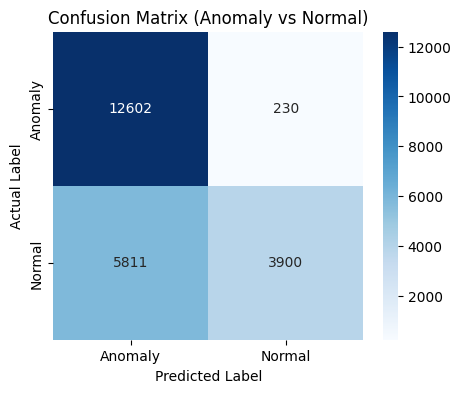

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [14]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.68      0.98      0.81     12832
      Normal       0.94      0.40      0.56      9711

    accuracy                           0.73     22543
   macro avg       0.81      0.69      0.69     22543
weighted avg       0.80      0.73      0.70     22543

Precision: 0.6844077553902135
Recall: 0.982076059850374
F1 Score: 0.8066570651304209
